<a target="_blank" href="https://colab.research.google.com/drive/1142VbFt8kLRz7amDi9UQt5LaJvIcTaZt?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# CircuitsDNA - Approximate Circuit Synthesis based on Evolutionary Algorithm 

```
Submission to IEEE SSCS Open-Source Ecosystem “Code-a-Chip” Travel Grant Awards at ISSCC'26
SPDX-License-Identifier: GPL-3.0-only
```


|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Ruichen Qi <br /> Email ID: ruichen_qi@brown.edu|Brown University|No|No|
|Junyi Luo <br /> Email ID: junyi_luo@brown.edu|Brown University|No|No|

<br>

---

## 1. Introduction



### 1.1 Background

According to Moore’s Law and Dennard scaling, continuous transistor miniaturization since 1974 has enabled exponential growth in device density—doubling with each generation—while maintaining higher clock speeds under constant power density. However, around 2007, the benefits of Dennard scaling began to fade due to leakage currents and power density constraints, and by 2012, scaling had largely halted.

Modern computing systems now face severe power and thermal bottlenecks. As transistor density continues to rise, heat dissipation has become a fundamental limitation: chips can no longer operate all transistors simultaneously without exceeding safe thermal limits. This results in “dark silicon,” where only a portion of the available cores can remain active to avoid overheating. Elevated temperatures also degrade device reliability, accelerating wear-out mechanisms and shortening system lifetime.

To address these challenges, approximate computing has emerged as a promising solution. By relaxing accuracy requirements in error-tolerant applications, approximate designs can substantially reduce power consumption and heat generation while maintaining acceptable output quality. This paradigm is especially suitable for neural network and large language model (LLM) accelerators, which are inherently resilient to small arithmetic errors. Minor inaccuracies in multiplications or accumulations typically have negligible impact on model accuracy, allowing designers to adopt approximate multipliers, adders, or reduced-precision datapaths for significant savings in power, area, and latency.

Moreover, fine-tuning techniques can further mitigate hardware-induced errors. By retraining or adapting model parameters on the approximate hardware, most of the lost accuracy can be recovered while retaining energy efficiency gains. This makes approximate computing particularly attractive for large-scale AI accelerators, where computational and memory demands are exceptionally high.

### 1.2 Motivation

Despite its promise, approximate computing still faces practical challenges in logic synthesis. Traditional design methods—such as manual simplification or heuristic gate pruning often rely on structural assumptions and struggle to scale for complex arithmetic blocks like multipliers. These methods typically yield locally optimized solutions and lack the flexibility to explore the vast combinational design space.

To overcome these limitations, genetic algorithms (GAs) offer an effective alternative. By evolving populations of candidate circuits through mutation, crossover, and selection, GAs can efficiently explore discrete, non-linear design spaces without requiring gradient information or explicit models. Their ability to support multi-objective optimization makes them ideal for balancing trade-offs among accuracy, power, area, and delay.

However, most GA-based approximate synthesis approaches remain limited to small-scale demonstrations and rarely connect circuit-level optimization to system-level evaluation. This work bridges that gap by introducing an end-to-end GA-driven framework that synthesizes approximate computing circuits and evaluates their real-world impact on neural network tasks such as image classifications

### 1.3 Notebook Overview

This notebook presents a genetic-algorithm–based framework for approximate logic synthesis and its application-level evaluation on deep learning models including Fashion-MNIST (LeNet-5) and CIFAR-100 (ResNet-18/ResNet-20).
The framework supports both random circuit generation and optimization from a seed netlist, providing a complete flow from synthesis to performance analysis.

Workflow summary:

An 8-bit signed multiplier is synthesized and verified using Yosys-ABC, iVerilog, and OpenSTA.

The genetic algorithm performs approximate logic synthesis on the extracted netlist under various error and area constraints.

The evolved approximate design is analyzed in OpenSTA to extract power, timing, and LUT information.

Finally, the approximate multipliers are integrated into deep learning workloads (LeNet-5, ResNet-18, and ResNet-20) to evaluate accuracy–efficiency trade-offs.

[FIgure] Workflow of our algorithm and approx multiplier based systolic array

---

## 2. Setting up of Open Source Tools

The latest versions of Yosys, iVerilog, and OpenSTA should be installed. There are many installation tutorials available online. You can either install them manually by following the instructions on their GitHub pages, or use the script we’ve provided:



In [ ]:
# Import modules
!make create_env
!make check_env

In [ ]:
!python -m venv venv
!venv/bin/python -m pip install --upgrade pip ipykernel
!venv/bin/python -m pip install -r requirements.txt
!venv/bin/python -m ipykernel install --user --name=venv --display-name "Python (venv)"

For the following steps, please switch the python kernal to the virtual environment we just created.

---

## 3. 8-bit Signed Multiplier Synthesis and Verification

In this demonstration, an 8-bit signed multiplier is synthesized and verified based on the GF180 technology as an example. All necessary files for synthesis and verification are prepared. Only six basic gate types — AND, NAND, OR, XOR, XNOR, and INV are used for synthesis, though the framework can be easily extended to include other logic gates or larger building blocks such as full adders (FA), barrel shifters, multipliers, etc. Here, we use these six gate types solely as a representative example.

Goldenbrick generation and behavior simulation:

In [ ]:
# Goldenbrick generation
!make goldenbrick_gen

# Behavior simulation
!make sim_behavior
!make check_behavior

Synthesis, post-synthesis simulation and verification:

In [ ]:
# Synthesis with a target frequency of 100MHz
!make run_synth

# Post-synthesis simulation and verification
!make sim_synth
!make check_synth

# Static Timing Analysis (STA)
!make sta

---
## 4. Approximate Multiplier Synthesis from the Synthesized Netlist via Genetic Algorithm

In this section, we use a genetic algorithm (GA) to evolve approximate 8-bit signed multipliers. Genetic algorithms struggle with large circuits due to the exponentially growing search space, high computational cost, and poor scalability. Therefore, our GA starts from the seed circuit, which is loaded from the synthesized Verilog netlist in previous step.

During each generation, the algorithm evaluates all candidate circuits by simulating their outputs over all input patterns. The fitness function jointly considers circuit accuracy and area efficiency — penalizing individuals with large worst-case errors (WCE > ε_th) while favoring smaller transistor counts. Multiple error metrics such as NMED, ER, WCE, MRE, and sMAPE are recorded for analysis.

New individuals are created through mutation operators, including:

Add / delete node: randomly insert or remove a gate;

Change gate type: switch to another logic primitive;

Rewire inputs or outputs: alter signal connectivity;

Merge equivalent nodes: remove redundant subcircuits.

By iteratively applying mutation, pruning inactive nodes, and selecting the best individuals, the GA searches the discrete, irregular design space to obtain compact approximate multipliers with bounded output error. This process enables automatic approximate logic synthesis directly at the gate level, providing a flexible framework for exploring accuracy–area trade-offs under the GF180 technology library.




[FIgure] Algorithm explaination

Since this algorithm is implemented using Cpp for acceleration, firstly we need to compile the code:

In [ ]:
# Compile the GA code
!make compile_ga

Then we're ready to evolve approximate logics using this algorithm. The evolution may take several hours to finish, depending on the performance of current platforms.

In [ ]:
# Start the GA evolution
!make run_ga

Here we use the evolution with an relative worst case error threshold of 0.5% as an example. All the experiments in this section were run on an AMD Ryzen 9 7845HX laptop for 14 hours.

<img src="images/evolution_process_epsEnd_0.005.png"
     alt="Evolution Process"
     style="width:800px;max-width:100%;border:1px solid #ccc;">

A grid search over the relative worst-case error threshold was performed, and the results are shown below. With only a 0.5% relative worst-case error, the equivalent transistor count was reduced to 76.5% of the original size.

<img src="images/equivalent_transistor_count_vs_epsEnd.png"
     alt="Evolution Process"
     style="width:800px;max-width:100%;border:1px solid #ccc;">

<img src="images/error_metrics_vs_epsEnd.png"
     alt="Evolution Process"
     style="width:800px;max-width:100%;border:1px solid #ccc;">

---
## 5. Analysis and Verification of Generated Approximate Multiplier

In this section, we map the generated netlist to a specific semiconductor technology (GF180, for example) and perform functional verification as well as power, performance, and area (PPA) analysis using OpenSTA. The design is mappd to standard cells from the target technology library, and timing, power, and area reports are extracted to evaluate the quality of the evolved approximate multiplier.



The program would save log files as well as the best evolved netlist file. In the log file you can get the equivelent transistor number, best fitness value and all the error metrics for each generation. The generated netlist file hasn't been mapped to a certain technology. Therefore, we need to map it to GF180 through: 

In [ ]:
# Map the generated netlist to GF180
!make map_netlist

Then we can extract the truth table of the generated approximate multiplier using the following command. In this step the mapped netlist would be instantialized in a testbench written in systemverilog and evaluated by behavior simulation using iVerilog.

In [ ]:
# Extract the truth table of the generated approximate multiplier
!make sim_approx_netlist

We can also check the error metrics from the extracted truth table for verifications

In [ ]:
# Todo: Error metrics verification
!make check_approx_netlist

---
## 6. Implementation of Deep Learning Tasks including Fashion-MNIST on LeNet-5 and CIFAR-100 on ResNet-18/ResNet-20 with Approximate Computing Unit

To begin this section, we fine-tune an INT8 quantized ResNet-20 on the CIFAR-100 dataset. This run demonstrates how the approximate arithmetic units integrate with a full image-classification workload before extending to additional models.

In [ ]:
# Quantization-aware training for CIFAR-100 ResNet-20 using helpers from train_qat_cifar100_resnet20.py
import os, sys, json, torch
from pathlib import Path

module_dir = Path("code/quant_code")
if not module_dir.is_dir():
    raise FileNotFoundError(f"Expected directory '{module_dir}' alongside this notebook.")
if str(module_dir.resolve()) not in sys.path:
    sys.path.insert(0, str(module_dir.resolve()))
repo_root = Path(".").resolve()

from train_qat_cifar100_resnet20 import (
    Cfg, get_loaders_cifar100, QResNet20CIFAR,
    train_one_epoch, evaluate, set_activation_quant_enabled,
    calibrate_activations, calibrate_weights
 )
from torch.optim.lr_scheduler import CosineAnnealingLR

cfg = Cfg()
cfg.data_root = str((repo_root / "datasets").resolve())
cfg.fp32_ckpt = str((repo_root / "runs_fp32" / "resnet20_cifar100_fp32.pt").resolve())
cfg.out_dir = str((repo_root / "runs_qat" / "resnet20").resolve())
os.makedirs(cfg.out_dir, exist_ok=True)

train_loader, test_loader = get_loaders_cifar100(cfg)
model = QResNet20CIFAR(num_classes=cfg.num_classes, cfg=cfg).to(cfg.device)

if cfg.fp32_ckpt and os.path.isfile(cfg.fp32_ckpt):
    sd = torch.load(cfg.fp32_ckpt, map_location='cpu')
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print(f'load_state: missing={len(missing)} unexpected={len(unexpected)}')
else:
    print('[Warn] fp32 checkpoint not found, training continues from scratch.')

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=cfg.lr_qat, momentum=cfg.momentum,
    weight_decay=cfg.weight_decay, nesterov=cfg.nesterov
 )

total_epochs = cfg.warmup_epochs + cfg.epochs_qat
scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs, eta_min=cfg.eta_min)

history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

set_activation_quant_enabled(model, in_enabled=False, out_enabled=False)
print(f'[Warm-up] epochs={cfg.warmup_epochs}')
for ep in range(1, cfg.warmup_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, cfg.device)
    te_loss, te_acc = evaluate(model, test_loader, cfg.device)
    cur_lr = optimizer.param_groups[0]['lr']
    print(f'[W{ep:02d}] lr {cur_lr:.2e} | train {tr_loss:.4f}/{tr_acc*100:.2f}% | test {te_loss:.4f}/{te_acc*100:.2f}%')
    scheduler.step()

calibrate_weights(model)

set_activation_quant_enabled(model, in_enabled=cfg.quantize_input, out_enabled=cfg.quantize_output)
print(f'[Calib-1] collecting {cfg.calib_steps} mini-batches...')
calibrate_activations(model, train_loader, cfg.device, cfg.calib_steps)

total_qat = cfg.epochs_qat
re_ep = int(total_qat * cfg.recalib_ratio) if cfg.recalib else -1

for ep in range(1, total_qat + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, cfg.device)
    te_loss, te_acc = evaluate(model, test_loader, cfg.device)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss);  history["test_acc"].append(te_acc)
    cur_lr = optimizer.param_groups[0]['lr']
    print(f'[QAT {ep:03d}] lr {cur_lr:.2e} | train {tr_loss:.4f}/{tr_acc*100:.2f}% | test {te_loss:.4f}/{te_acc*100:.2f}%')
    scheduler.step()
    if cfg.recalib and ep == re_ep:
        print(f'[Calib-2 @ QAT {ep}] collecting {cfg.calib_steps} mini-batches...')
        calibrate_activations(model, train_loader, cfg.device, cfg.calib_steps)

torch.save(model.state_dict(), os.path.join(cfg.out_dir, cfg.ckpt))
with open(os.path.join(cfg.out_dir, cfg.hist), 'w') as f:
    json.dump(history, f)

te_loss, te_acc = evaluate(model, test_loader, cfg.device)
print(f'INT8 final: loss {te_loss:.4f}, acc {te_acc*100:.2f}%')

We also run a diagnostic experiment: if we simply reuse the INT8 weights from the baseline network while swapping in the approximate multiplier, the classification accuracy collapses rapidly. This highlights that hardware-aware fine-tuning is essential—the quantized weights alone cannot compensate for the extra arithmetic error introduced by the approximate units.

In [ ]:
from dataclasses import dataclass
from pathlib import Path
import time, torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from resnet20_lut import ResNet20LUTCfg, build_lut_resnet20, resolve_lut_table


@dataclass
class Cfg(ResNet20LUTCfg):
    test_subset: int | None = None
    lut_table_path: str | None = 'code/lut/truth_table_0.5.csv'
    qat_ckpt: str = 'runs_qat/resnet20/resnet20_cifar100_qat_int8.pt'
    # lut_table_path: str | None = None



def get_test_loader(cfg: Cfg) -> DataLoader:
    mean = [0.5071, 0.4865, 0.4409]
    std = [0.2673, 0.2564, 0.2762]
    test_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    test_set = datasets.CIFAR100(cfg.data_root, train=False, download=True, transform=test_tf)
    if cfg.test_subset is not None and cfg.test_subset < len(test_set):
        indices = torch.arange(cfg.test_subset)
        test_set = Subset(test_set, indices)
    return DataLoader(test_set, batch_size=cfg.batch_sz, shuffle=False,
                      num_workers=cfg.num_workers, pin_memory=True)




@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: str) -> tuple[float, float, float]:
    model.eval()
    total = 0
    correct = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    if device.startswith('cuda'):
        torch.cuda.synchronize()
    t0 = time.time()
    total_batches = len(loader)
    for step, (x, y) in enumerate(loader, 1):
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
        if step % max(1, total_batches // 10) == 0 or step == total_batches:
            print(f'[Eval] processed {step}/{total_batches} batches...')
    if device.startswith('cuda'):
        torch.cuda.synchronize()
    elapsed = time.time() - t0
    avg_loss = total_loss / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc, elapsed

cfg = Cfg()
device = cfg.device
torch.backends.cudnn.benchmark = True

if cfg.lut_table_path is not None:
    base_dir = Path.cwd()
    resolve_lut_table(cfg, base_dir)
    print(f'[Info] Loaded LUT truth table: {cfg.lut_table_path}')

print('[Info] Building LUT ResNet-20 and loading QAT checkpoint...')
print(f'[Info] Using checkpoint at: {cfg.qat_ckpt}')
model = build_lut_resnet20(cfg).to(device)

print('[Info] Preparing CIFAR-100 test set...')
test_loader = get_test_loader(cfg)

print('[Info] Starting evaluation...')
loss, acc, elapsed = evaluate(model, test_loader, device)
samples = len(test_loader.dataset)
print(f'[Result] test_loss={loss:.4f}, test_acc={acc*100:.2f}%, time={elapsed:.2f}s, throughput={samples/elapsed:.1f} samples/s')

We now begin fine-tuning. Note that we substitute the gradient of the exact multiplier for the gradient of the approximate multiplier; this keeps the update direction aligned with reducing the network loss, so each step still moves us downhill.

In [5]:
import json
import os, sys
import time
from dataclasses import dataclass
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

module_dir = Path("code/quant_code")
if not module_dir.is_dir():
    raise FileNotFoundError(f"Expected directory '{module_dir}' alongside this notebook.")
module_path = str(module_dir.resolve())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from resnet20_lut import (
    QResNet20CIFARLUT,
    ResNet20LUTCfg,
    build_lut_resnet20,
    resolve_lut_table,
 )


@dataclass
class Cfg(ResNet20LUTCfg):
    qat_ckpt: str = 'runs_qat/resnet20/resnet20_cifar100_qat_int8.pt'  # QAT weight path
    epochs: int = 5
    lr: float = 5e-4
    weight_decay: float = 1e-4
    momentum: float = 0.9
    nesterov: bool = True
    log_interval: int = 100
    eta_min: float = 1e-5
    output_dir: str = 'runs_qat/resnet20'
    save_path: str | None = None
    resume_path: str | None = None
    history_path: str | None = None
    lut_table_path: str | None = 'code/lut/truth_table_0.5.csv'
    num_workers: int = 0  # avoid duplicate prints from worker processes


def get_loaders(cfg: Cfg) -> tuple[DataLoader, DataLoader]:
    mean = [0.5071, 0.4865, 0.4409]
    std = [0.2673, 0.2564, 0.2762]
    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    test_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    train_set = datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=train_tf)
    test_set = datasets.CIFAR100(cfg.data_root, train=False, download=True, transform=test_tf)
    train_loader = DataLoader(
        train_set, batch_size=cfg.batch_sz, shuffle=True, num_workers=cfg.num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_set, batch_size=cfg.batch_sz, shuffle=False, num_workers=cfg.num_workers, pin_memory=True
    )
    return train_loader, test_loader


def infer_lut_tag(lut_path: str | None) -> str:
    if not lut_path:
        return 'exact'
    stem = os.path.splitext(os.path.basename(lut_path))[0]
    candidate = stem.split('_')[-1] if '_' in stem else stem
    candidate = candidate.strip()
    return candidate or 'custom'


def train_one_epoch(
    model: QResNet20CIFARLUT,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: str,
    log_interval: int,
 ) -> tuple[float, float]:
    model.train()
    total = 0
    correct = 0
    loss_sum = 0.0
    for step, (x, y) in enumerate(loader, 1):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
        if step % max(1, log_interval) == 0:
            print(
                f'[Train] step={step:04d} loss={loss.item():.4f} acc={(correct/total)*100:.2f}%',
                flush=True,
            )
    return loss_sum / max(total, 1), correct / max(total, 1)


@torch.no_grad()
def evaluate(model: QResNet20CIFARLUT, loader: DataLoader, device: str) -> tuple[float, float]:
    model.eval()
    total = 0
    correct = 0
    loss_sum = 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss_sum += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)
    return loss_sum / max(total, 1), correct / max(total, 1)


def build_model(cfg: Cfg) -> QResNet20CIFARLUT:
    if cfg.qat_ckpt and os.path.isfile(cfg.qat_ckpt):
        model = build_lut_resnet20(cfg)
    elif cfg.resume_path:
        print('[Warn] Initial QAT checkpoint not found, falling back to resume only.')
        model = QResNet20CIFARLUT(num_classes=cfg.num_classes, cfg=cfg)
    else:
        raise FileNotFoundError('Missing initial QAT weights; set cfg.qat_ckpt or provide resume_path')
    if cfg.resume_path and os.path.isfile(cfg.resume_path):
        print(f'[Info] Resume from {cfg.resume_path}')
        state = torch.load(cfg.resume_path, map_location='cpu')
        model.load_state_dict(state, strict=False)
    return model

cfg = Cfg()
device = cfg.device
torch.backends.cudnn.benchmark = True
if cfg.lut_table_path is not None:
    base_dir = Path.cwd()
    resolve_lut_table(cfg, base_dir)
    print(f'[Info] Loaded LUT table: {cfg.lut_table_path}')
lut_tag = infer_lut_tag(cfg.lut_table_path)
if cfg.save_path is None:
    cfg.save_path = os.path.join(cfg.output_dir, f'resnet20_cifar100_qat_int8_lut_{lut_tag}_ft.pt')
if cfg.history_path is None:
    cfg.history_path = os.path.join(cfg.output_dir, f'history_ft_resnet20_lut_{lut_tag}.json')
train_loader, test_loader = get_loaders(cfg)
model = build_model(cfg).to(device)
optimizer = torch.optim.SGD(
    model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay, nesterov=cfg.nesterov
 )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs, eta_min=cfg.eta_min)
best_acc = 0.0
history: dict[str, list[float]] = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
}
for epoch in range(1, cfg.epochs + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, cfg.log_interval)
    test_loss, test_acc = evaluate(model, test_loader, device)
    scheduler.step()
    elapsed = time.time() - t0
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    print(
        f"[Epoch {epoch:03d}] {elapsed:.1f}s | train {train_loss:.4f}/{train_acc*100:.2f}% | "
        f"test {test_loss:.4f}/{test_acc*100:.2f}% | lr={optimizer.param_groups[0]['lr']:.2e}",
        flush=True,
    )
    if test_acc > best_acc:
        best_acc = test_acc
        os.makedirs(os.path.dirname(cfg.save_path), exist_ok=True)
        torch.save(model.state_dict(), cfg.save_path)
        print(f'[Info] Saved new best model -> {cfg.save_path} (acc={best_acc*100:.2f}%)', flush=True)
print(f'[Done] Best test accuracy: {best_acc*100:.2f}%')
os.makedirs(os.path.dirname(cfg.history_path), exist_ok=True)
with open(cfg.history_path, 'w') as f:
    json.dump(history, f)
print(f'[Info] Training history saved to {cfg.history_path}')

[Info] Loaded LUT table: /home/junyi/projects/sscs-ose-code-a-chip.github.io/ISSCC26/CircuitsDNA/code/lut/truth_table_0.5.csv
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[Train] step=0100 loss=0.7439 acc=73.48%
[Train] step=0100 loss=0.7439 acc=73.48%
[Train] step=0200 loss=0.5631 acc=76.96%
[Train] step=0200 loss=0.5631 acc=76.96%
[Train] step=0300 loss=0.6578 acc=78.41%
[Train] step=0300 loss=0.6578 acc=78.41%
[Epoch 001] 151.8s | train 0.7063/79.36% | test 1.2279/66.75% | lr=4.53e-04
[Epoch 001] 151.8s | train 0.7063/79.36% | test 1.2279/66.75% | lr=4.53e-04
[Info] Saved new best model -> runs_qat/resnet20/resnet20_cifar100_qat_int8_lut_0.5_ft.pt (acc=66.75%)
[Info] Saved new best model -> runs_qat/resnet20/resnet20_cifar100_qat_int8_lut_0.5_ft.pt (acc=66.75%)
[Train] step=0100 loss=0.5661 acc=82.84%
[Train] step=0100 loss=0.5661 acc=82.84%
[Train] step=0200 loss=0.4675 acc=83

Plot the logs to see the trend

Saved: runs_qat/resnet20/history_qat_resnet20.json.png


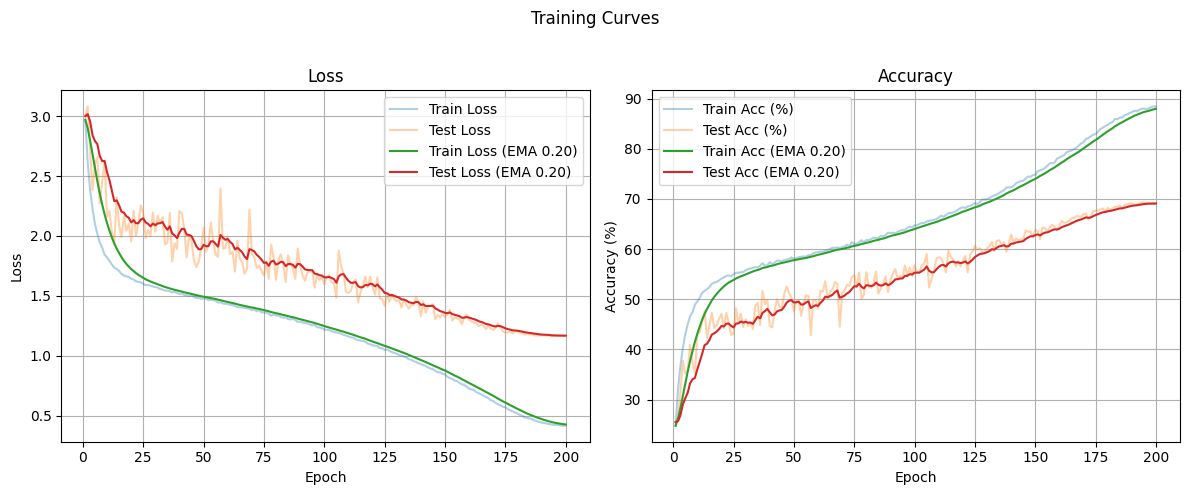

In [8]:
import json, os
import matplotlib.pyplot as plt

history_path = "runs_qat/resnet20/history_qat_resnet20.json"   
save_path    = "runs_qat/resnet20/history_qat_resnet20.json.png"     
title        = "Training Curves"
smooth_alpha = 0.2  # Exponential smoothing parameters, 0 or None indicate that no smoothing is used.


def _resolve_alpha(alpha):
    if alpha is None:
        return None
    try:
        alpha = float(alpha)
    except (TypeError, ValueError):
        return None
    if alpha <= 0:
        return None
    return alpha


ema_alpha = _resolve_alpha(smooth_alpha)
raw_alpha = 0.35 if ema_alpha else 0.9

def ema(xs, alpha=0.2):
    if xs is None: return None
    out = []
    m = None
    for v in xs:
        m = v if m is None else (alpha * v + (1 - alpha) * m)
        out.append(m)
    return out

def load_history(p):
    with open(p, "r") as f:
        raw = json.load(f)
    keys = ["train_loss", "test_loss", "train_acc", "test_acc"]
    if isinstance(raw, list):
        hist = {k: [] for k in keys}
        for entry in raw:
            for k in keys:
                hist[k].append(entry.get(k, 0.0))
        return hist
    for k in keys:
        raw.setdefault(k, [])
    return raw

history = load_history(history_path)
epochs = list(range(1, len(history["train_loss"]) + 1))

TL, TeL = history["train_loss"], history["test_loss"]
TA, TeA = history["train_acc"], history["test_acc"]

if ema_alpha:
    TLs, TeLs = ema(TL, ema_alpha), ema(TeL, ema_alpha)
    TAs, TeAs = ema(TA, ema_alpha), ema(TeA, ema_alpha)
else:
    TLs, TeLs, TAs, TeAs = TL, TeL, TA, TeA

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, TL,  label="Train Loss", alpha=raw_alpha)
plt.plot(epochs, TeL, label="Test Loss",  alpha=raw_alpha)
if ema_alpha:
    plt.plot(epochs, TLs, label=f"Train Loss (EMA {ema_alpha:.2f})", alpha=1.0)
    plt.plot(epochs, TeLs, label=f"Test Loss (EMA {ema_alpha:.2f})", alpha=1.0)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
plt.grid(True); plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, [a*100 for a in TA],  label="Train Acc (%)", alpha=raw_alpha)
plt.plot(epochs, [a*100 for a in TeA], label="Test Acc (%)",  alpha=raw_alpha)
if ema_alpha:
    plt.plot(epochs, [a*100 for a in TAs],  label=f"Train Acc (EMA {ema_alpha:.2f})", alpha=1.0)
    plt.plot(epochs, [a*100 for a in TeAs], label=f"Test Acc (EMA {ema_alpha:.2f})", alpha=1.0)
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy")
plt.grid(True); plt.legend()

plt.suptitle(title)
plt.tight_layout(rect=[0,0,1,0.96])

if save_path:
    os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
    plt.savefig(save_path, dpi=180)
    print(f"Saved: {save_path}")

plt.show()

Readers can refer to the scripts in `code/quant_code` to fine-tune larger networks—such as ResNet-18—under the approximate multiplier configuration.

---
## 7. Discussion


---
## 8. Conclusion


In conclusion, 